---
# [NideconvFitter](https://linescanning.readthedocs.io/en/latest/classes/fitting.html#linescanning.fitting.NideconvFitter)

This notebook illustrates how to perform a deconvolution using `nideconv` and specific classes from this repository. First, we read the data in with `linescanning.dataset.Dataset`, which formats our functional data and onset timings the way nideconv likes it. Then I show some useful functions to select specific portions of a larger dataframe. Then, we perform the fitting and do some plotting

In [1]:
# imports
from linescanning import dataset, plotting, utils, fitting
import warnings
import os
import matplotlib.pyplot as plt
from scipy.io import loadmat
import seaborn as sns

warnings.simplefilter('ignore')
project_dir     = "/data1/projects/MicroFunc/Jurjen/projects"
base_dir        = opj(project_dir, 'hemifield')
deriv_dir       = opj(base_dir, 'derivatives')

plot_vox = 359
plot_xkcd = False

Load in some data. You could substitute this with the example data provided with the repository. However, when I did the deconvolution on that data the results didn't look good enough for illustrative purposes. So I have a different dataset here: 3 runs of a Size-Response experiment in which our target pRF was bombarded with flickering stimuli of 5 different sizes.

In [3]:
    # Load data
sub         = '003'
ses         = 3
task        = "task-SR"
runs        = [3,4,6]
func_dir    = opj(base_dir, f"sub-{sub}", f"ses-{ses}", "func")
ribbon      = (356,363)

run_files = utils.get_file_from_substring([f"sub-{sub}", f"ses-{ses}", f"{task}"], func_dir)
func_file   = utils.get_file_from_substring("bold.mat", run_files)
exp_file   = utils.get_file_from_substring("events.tsv", run_files)
func_file


['/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-3_bold.mat',
 '/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-4_bold.mat',
 '/data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-6_bold.mat']

Here we plop everything in `Dataset`, which will automatically format the functional data and onset timings for us

In [4]:
window = 19
order = 3

## window 5 TR poly 2
data_obj = dataset.Dataset(
    func_file,
    deleted_first_timepoints=50,
    deleted_last_timepoints=50,
    tsv_file=exp_file,
    standardization="psc",
    use_bids=True,
    verbose=True)

df_func     = data_obj.fetch_fmri()
df_onsets   = data_obj.fetch_onsets()
df_func

DATASET

FUNCTIONAL
Preprocessing /data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-3_bold.mat
 Filtering strategy: 'hp'
 Standardization strategy: 'psc'
 Baseline is 20 seconds, or 190 TRs
 Cutting 50 volumes from beginning (also cut from baseline (was 190, now 140 TRs) | 50 volumes from end
 DCT-high pass filter [removes low frequencies <0.01 Hz] to correct low-frequency drifts.
 tSNR [no cleaning]: 18.57	| variance: 0.76
Preprocessing /data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-003/ses-3/func/sub-003_ses-3_task-SR_run-4_bold.mat
 Filtering strategy: 'hp'
 Standardization strategy: 'psc'
 Baseline is 20 seconds, or 190 TRs
 Cutting 50 volumes from beginning (also cut from baseline (was 190, now 140 TRs) | 50 volumes from end
 DCT-high pass filter [removes low frequencies <0.01 Hz] to correct low-frequency drifts.
 tSNR [no cleaning]: 19.9	| variance: 0.7
Preprocessing /data1/projects/MicroFunc/Jurjen/projects/hemifield/sub-00

vox 0      vox 1      vox 2      vox 3      vox 4  \
subject run t                                                                
003     3   0.000   -12.112968  19.506470   2.824623   4.858002  18.645103   
            0.105     4.666885   2.531631   1.025208 -18.671684  10.393379   
            0.210    16.257484   4.003906  -9.382889  13.984055   2.706932   
            0.315     0.886009   2.582954  10.709297  11.684601   3.227837   
            0.420    -0.394203 -12.422836  -4.406075  20.674042  -3.449020   
...                        ...        ...        ...        ...        ...   
        6   450.975 -16.968468  -1.933022  -3.851868   2.879868  -1.720558   
            451.080   6.370689  15.884895   0.679214  -5.673798   5.454056   
            451.185  -8.917702 -15.020752   2.017090 -14.353874  -6.002953   
            451.290  -3.402466  -2.567574 -11.832848  -3.837036  -9.614151   
            451.395  -3.352692  -0.432274  12.870880   7.134697  -0.377335   

                         vox 5      vox 6      vox 7      vox 8     vox 9  \
subject run t                                                               
003     3   0.000    -2.485558  -6.216919   7.644806   0.117371  6.472908   
            0.105    12.552147   0.722404   3.682724  -8.450172 -1.327126   
            0.210    13.688568   1.906990  -9.894966   8.269630 -4.537666   
            0.315    17.266602  15.199478   3.357285  -1.714493  8.968109   
            0.420     4.288391   2.411728   0.899651  10.229424  5.472664   
...                        ...        ...        ...        ...       ...   
        6   450.975   2.782768   5.106194  -6.267616   9.162407 -2.001717   
            451.080   2.877632  -0.669907   4.443268   5.889519  7.889275   
            451.185  -4.093712  -2.435738 -14.841270   1.449539 -9.234657   
            451.290  -3.799995   0.346992  -2.144806  -8.050407 -7.654427   
            451.395   7.746712   1.689529  -5.669823   2.193672 -3.824074   

                     ...    vox 710    vox 711    vox 712    vox 713  \
subject run t        ...                                               
003     3   0.000    ...  -6.598740   1.931831 -24.877098  10.088448   
            0.105    ...  36.637909  -0.559746  55.097725  65.572563   
            0.210    ...  17.508385 -38.955162 -25.645264  20.689186   
            0.315    ... -20.445503  30.488655  -2.957588 -12.083633   
            0.420    ...  14.946091   1.035431 -41.714191  -0.333504   
...                  ...        ...        ...        ...        ...   
        6   450.975  ... -21.017609  -2.732735   3.540390   7.482758   
            451.080  ... -20.272133  -3.153091  17.593964 -12.577377   
            451.185  ... -29.918221 -12.623344  30.750786  23.410027   
            451.290  ... -18.555824 -18.418892  -9.471703  42.564392   
            451.395  ...  14.384300  13.308815  -5.738548  39.509338   

                       vox 714    vox 715    vox 716    vox 717    vox 718  \
subject run t                                                                
003     3   0.000    19.764313  36.417015  -5.627525 -36.341358 -37.167282   
            0.105    25.778519 -17.483330  42.961082  45.405258 -24.064095   
            0.210    26.801971 -31.645752 -14.109596  -7.489403 -84.622162   
            0.315     8.490105  -1.388046  28.978462  37.057465 -32.214935   
            0.420    32.325989 -21.178391  12.479088 -46.943787 -35.050156   
...                        ...        ...        ...        ...        ...   
        6   450.975   4.214661   7.507225  55.524872  14.318832   6.575912   
            451.080  11.167923  19.854065  58.259186 -40.992596 -17.050148   
            451.185   0.281418   3.630928 -26.330490  -6.517128 -19.148064   
            451.290  30.646057  -2.343399  35.635635  -3.880394 -36.661835   
            451.395 -12.725807   9.444901 -23.167389 -51.609962  17.805450   

                       vox 719  
subject run t          

Now we have our data formatted the way `nideconv` likes it: the functional data is indexed by `subject`, `run`, and `t`, while the onset dataframe is indexed by `subject`, `run`, and `event_type`:

In [5]:
df_func.head()


vox 0      vox 1      vox 2      vox 3      vox 4  \
subject run t                                                              
003     3   0.000 -12.112968  19.506470   2.824623   4.858002  18.645103   
            0.105   4.666885   2.531631   1.025208 -18.671684  10.393379   
            0.210  16.257484   4.003906  -9.382889  13.984055   2.706932   
            0.315   0.886009   2.582954  10.709297  11.684601   3.227837   
            0.420  -0.394203 -12.422836  -4.406075  20.674042  -3.449020   

                       vox 5      vox 6     vox 7      vox 8     vox 9  ...  \
subject run t                                                           ...   
003     3   0.000  -2.485558  -6.216919  7.644806   0.117371  6.472908  ...   
            0.105  12.552147   0.722404  3.682724  -8.450172 -1.327126  ...   
            0.210  13.688568   1.906990 -9.894966   8.269630 -4.537666  ...   
            0.315  17.266602  15.199478  3.357285  -1.714493  8.968109  ...   
            0.420   4.288391   2.411728  0.899651  10.229424  5.472664  ...   

                     vox 710    vox 711    vox 712    vox 713    vox 714  \
subject run t                                                              
003     3   0.000  -6.598740   1.931831 -24.877098  10.088448  19.764313   
            0.105  36.637909  -0.559746  55.097725  65.572563  25.778519   
            0.210  17.508385 -38.955162 -25.645264  20.689186  26.801971   
            0.315 -20.445503  30.488655  -2.957588 -12.083633   8.490105   
            0.420  14.946091   1.035431 -41.714191  -0.333504  32.325989   

                     vox 715    vox 716    vox 717    vox 718    vox 719  
subject run t                                                             
003     3   0.000  36.417015  -5.627525 -36.341358 -37.167282   8.782722  
            0.105 -17.483330  42.961082  45.405258 -24.064095 -20.184967  
            0.210 -31.645752 -14.109596  -7.489403 -84.622162  16.263290  
            0.315  -1.388046  28.978462  37.057465 -32.214935   7.495415  
            0.420 -21.178391  12.479088 -46.943787 -35.050156 -22.763206  

[5 rows x 720 columns]

In [6]:
df_onsets.head()

onset
subject run event_type                  
003     3   2.014613132977678  24.363776
            3.5652478065289    35.213706
            2.13914868391734   39.913720
            3.5652478065289    47.413652
            2.014613132977678  53.213640

Theoretically, `nideconv` should be able to concatenate multiple runs. Unfortunately, I haven't been able to get this to work yet, so what you can do instead is run the fitter for separate runs and then average the results. Alternatively, you can concatenate the runs yourself, but that becomes tricky with onset times (maybe I should implement such an option in `linescanning.dataset.Dataset`..). 

In any case, you can select portions of dataframes using `utils.select_from_df` given an expression. This expression is written in the form of how you say it. For instance: "_I want the data of subject 1 and run 1_", you'd specify: `utils.select_from_df(<dataframe>, expression=("subject = 1", "and", "run = 1"))`. The spaces in the expression are mandatory, as well as a separate operator in case you have multiple conditions. This is because, internally, the operator must be converted from string to operator-function. 

If your dataframe was indexed, you'll be returned a subset of the dataframe conform your expression with the same indexing.

In [7]:
# this is a bit simple because we only have 3 run in this dataset, but it illustrates the principle
utils.select_from_df(df_func, expression="run = 3")

vox 0      vox 1      vox 2      vox 3      vox 4  \
subject run t                                                                
003     3   0.000   -12.112968  19.506470   2.824623   4.858002  18.645103   
            0.105     4.666885   2.531631   1.025208 -18.671684  10.393379   
            0.210    16.257484   4.003906  -9.382889  13.984055   2.706932   
            0.315     0.886009   2.582954  10.709297  11.684601   3.227837   
            0.420    -0.394203 -12.422836  -4.406075  20.674042  -3.449020   
...                        ...        ...        ...        ...        ...   
            450.975   1.725731 -15.144714 -19.009155  -3.102150  12.564888   
            451.080  -3.356529   3.235062   6.483208   8.875519  -6.379730   
            451.185  -6.879913   2.792343  -2.592278   0.779831   1.908806   
            451.290   5.931419  -3.274689  17.510986   5.629753   0.361130   
            451.395  -5.419510  -1.785980  -0.812332   1.738518   4.302994   

                         vox 5      vox 6      vox 7      vox 8      vox 9  \
subject run t                                                                
003     3   0.000    -2.485558  -6.216919   7.644806   0.117371   6.472908   
            0.105    12.552147   0.722404   3.682724  -8.450172  -1.327126   
            0.210    13.688568   1.906990  -9.894966   8.269630  -4.537666   
            0.315    17.266602  15.199478   3.357285  -1.714493   8.968109   
            0.420     4.288391   2.411728   0.899651  10.229424   5.472664   
...                        ...        ...        ...        ...        ...   
            450.975   2.306580   1.190056  -5.206390   3.865814 -11.063164   
            451.080  -4.626564 -13.571541 -10.956978   3.768692  -4.126717   
            451.185 -12.933929   8.834854   6.723106 -11.457649  12.841576   
            451.290  13.059998  -9.553940   4.909546   1.226761  -6.461479   
            451.395  -0.589066   5.135925   7.422478  -2.608772   5.147690   

                     ...    vox 710    vox 711    vox 712    vox 713  \
subject run t        ...                                               
003     3   0.000    ...  -6.598740   1.931831 -24.877098  10.088448   
            0.105    ...  36.637909  -0.559746  55.097725  65.572563   
            0.210    ...  17.508385 -38.955162 -25.645264  20.689186   
            0.315    ... -20.445503  30.488655  -2.957588 -12.083633   
            0.420    ...  14.946091   1.035431 -41.714191  -0.333504   
...                  ...        ...        ...        ...        ...   
            450.975  ...  11.005417  43.028572 -13.639664 -11.605675   
            451.080  ... -26.043411  51.461571  19.043587 -24.526794   
            451.185  ...  19.375526  38.798744  10.708488 -27.424278   
            451.290  ... -10.643494  22.493546  36.711357 -17.700424   
            451.395  ...  -2.996056  18.514374  -2.529625   5.339706   

                       vox 714    vox 715    vox 716    vox 717    vox 718  \
subject run t                                                                
003     3   0.000    19.764313  36.417015  -5.627525 -36.341358 -37.167282   
            0.105    25.778519 -17.483330  42.961082  45.405258 -24.064095   
            0.210    26.801971 -31.645752 -14.109596  -7.489403 -84.622162   
            0.315     8.490105  -1.388046  28.978462  37.057465 -32.214935   
            0.420    32.325989 -21.178391  12.479088 -46.943787 -35.050156   
...                        ...        ...        ...        ...        ...   
            450.975 -26.643242  11.073257  34.346077 -15.131874  -3.783920   
            451.080   6.236290   6.885307  -4.252258   4.819321   9.252182   
            451.185 -26.934189 -29.444199   2.804276  19.032402 -25.089104   
            451.290 -57.566364 -13.176224  25.810303  30.254288  17.943405   
            451.395   3.317848 -44.731350  17.661545 -22.539970 -18.592567   

                       vox 719  
subject ru

We can also select only the voxels from the GM-ribbon. For convenience, we'll continue with this subset of the dataframe for our fitting

In [8]:
df_ribbon = utils.select_from_df(df_func, expression='ribbon', indices=ribbon)
df_ribbon


vox 356   vox 357   vox 358   vox 359   vox 360  \
subject run t                                                           
003     3   0.000   -0.071739  0.167107 -0.144806 -4.456978 -4.997894   
            0.105   -2.024399 -3.539673 -1.894897 -1.422615 -0.659103   
            0.210   -1.272415  0.316490  1.884216  0.062370 -3.012459   
            0.315    1.462990  1.300804  3.058662 -0.195541  2.700043   
            0.420    2.638489  3.550682  1.020058  3.021248 -0.796242   
...                       ...       ...       ...       ...       ...   
        6   450.975  1.175598  3.093842  0.262177  1.514366 -0.397339   
            451.080  4.563950  0.574020  3.470749  2.962746  3.178062   
            451.185 -2.680687  1.237396  0.730515 -0.935905 -0.360039   
            451.290  3.334953 -1.183098  0.452560  1.486267  1.584473   
            451.395 -1.214912 -1.032112  0.330559 -0.220901  1.206627   

                      vox 361   vox 362  
subject run t                            
003     3   0.000   -8.061729 -6.211449  
            0.105   -0.154816  1.179634  
            0.210   -2.817741 -1.851486  
            0.315   -0.468964  2.553284  
            0.420    0.847038 -2.357117  
...                       ...       ...  
        6   450.975  3.008080  1.352455  
            451.080  1.342949  0.326973  
            451.185  2.012772 -0.274796  
            451.290 -1.043343  0.097862  
            451.395  1.044044  0.799171  

[13300 rows x 7 columns]

In [9]:
# this also works for onset dataframes
utils.select_from_df(df_onsets, expression="run = 3")

onset
subject run event_type                   
003     3   2.014613132977678   24.363776
            3.5652478065289     35.213706
            2.13914868391734    39.913720
            3.5652478065289     47.413652
            2.014613132977678   53.213640
            3.5652478065289     60.755378
            1.853928859395028   65.730180
            1.853928859395028   78.388490
            3.5652478065289     91.713437
            1.140879298089248  101.380051
            1.140879298089248  107.305134
            1.853928859395028  113.854985
            1.853928859395028  118.821583
            1.140879298089248  124.246617
            2.014613132977678  134.221550
            2.13914868391734   143.271515
            3.5652478065289    148.613325
            1.140879298089248  156.696457
            3.5652478065289    165.754301
            1.140879298089248  173.188099
            2.13914868391734   177.813011
            2.014613132977678  183.387938
            1.140879298089248  189.746253
            1.140879298089248  197.829608
            2.014613132977678  203.704453
            2.13914868391734   209.404494
            3.5652478065289    214.246153
            3.5652478065289    219.679502
            1.853928859395028  229.487711
            1.853928859395028  236.129379
            2.13914868391734   253.129303
            1.853928859395028  263.112592
            1.853928859395028  269.629237
            2.13914868391734   274.529287
            2.13914868391734   280.462811
            2.014613132977678  285.129148
            1.853928859395028  291.412421
            2.014613132977678  300.354080
            2.014613132977678  306.204038
            2.014613132977678  314.637343
            2.014613132977678  320.537317
            1.140879298089248  333.486816
            1.140879298089248  344.870505
            1.140879298089248  354.812066
            1.853928859395028  360.437064
            3.5652478065289    365.712135
            3.5652478065289    370.870303
            2.13914868391734   376.503695
            2.13914868391734   386.603704
            2.13914868391734   392.345201

Right, on to the fitting: we can do the fitting with `utils.NideconvFitter`, which requires the functional dataframe, onset dataframe, and some settings on the type of fit you'd like to do, number of regressors, confounds, etc

In [299]:
nd_fit = fitting.NideconvFitter(
    df_ribbon,
    df_onsets,
    basis_sets='canonical_hrf_with_time_derivative',
    lump_events=False,
    TR=0.105,
    interval=[-3,17],
    add_intercept=True,
    verbose=True,
    fit=True)

nd_fit.timecourses_condition()

Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event '1.140879298089248' to model
Adding event '1.853928859395028' to model
Adding event '2.014613132977678' to model
Adding event '2.13914868391734' to model
Adding event '3.5652478065289' to model
Fitting with 'ols' minimization
Done


With `plot_average_per_event`, we can plot the average response across the voxels in the dataframe for each event in the model. We can also prettify the figure by adding an inset containing the `time-to-peak` barplot

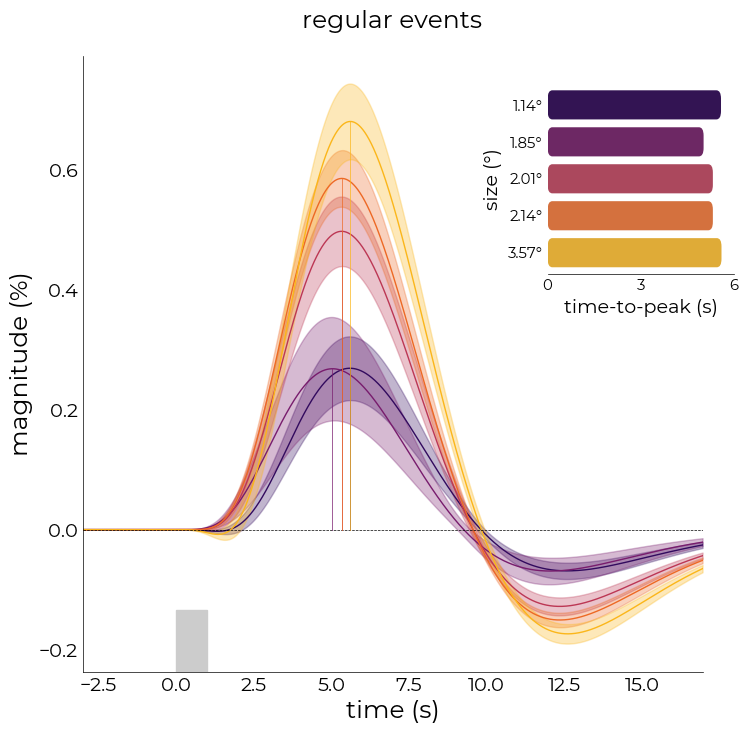

In [286]:
%matplotlib inline
fig,axs = plt.subplots(figsize=(8,8))
nd_fit.plot_average_per_event(
    xkcd=plot_xkcd, 
    x_label="time (s)",
    y_label="magnitude (%)",
    add_hline='default',
    axs=axs,
    ttp=True,
    lim=[0, 6],
    ticks=[0, 3, 6],
    ttp_lines=True,
    y_label2="size (°)",
    x_label2="time-to-peak (s)", 
    title="regular events",
    ttp_labels=[f"{round(float(ii),2)}°" for ii in nd_fit.cond],
    add_labels=True,   
    fancy=True,                 
    cmap='inferno')

# plot stimulus onset 
axs.axvspan(0,1, ymax=0.1, color="#cccccc")

Or `full-with half maximum` (FWHM)

Flipping events to ['3.5652478065289' '2.13914868391734' '2.014613132977678'
 '1.853928859395028' '1.140879298089248']


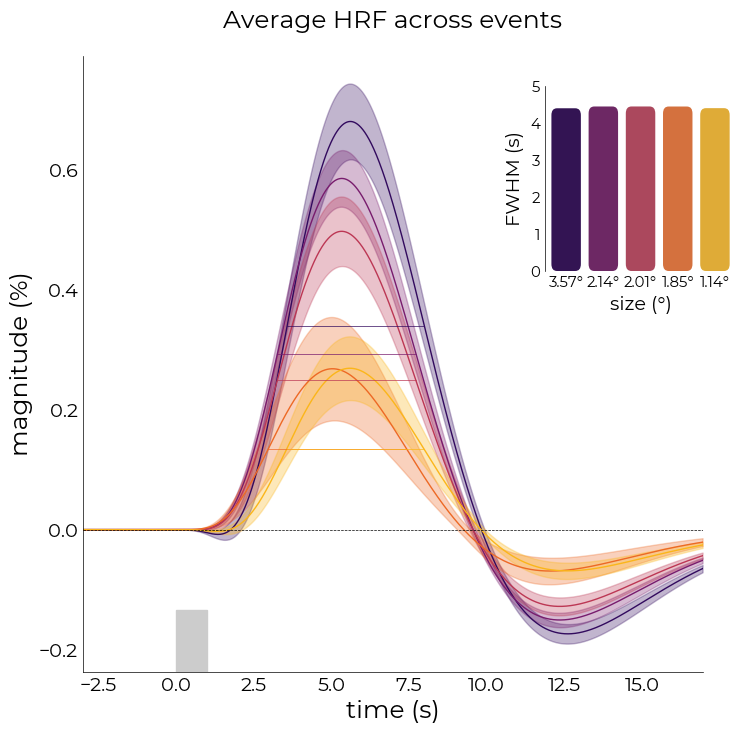

In [288]:
fig,axs = plt.subplots(figsize=(8,8))
nd_fit.plot_average_per_event(
    x_label="time (s)",
    y_label="magnitude (%)",
    add_hline='default',
    axs=axs,
    fwhm=True,
    fwhm_lines=True,
    lim=[0,5],
    ticks=[i for i in range(6)],
    fwhm_labels=[f"{round(float(ii),2)}°" for ii in nd_fit.cond[::-1]],
    events=nd_fit.cond[::-1],
    add_labels=True,
    x_label2="size (°)",
    y_label2="FWHM (s)",  
    fancy=True,
    cmap='inferno')

# plot stimulus onset 
axs.axvspan(0,1, ymax=0.1, color="#cccccc")

In [300]:
# individual model fits
fit_objs = []
for ii in nd_fit.cond:

    nd_ = fitting.NideconvFitter(
        df_ribbon,
        utils.select_from_df(df_onsets, expression=f"event_type = {ii}"),
        basis_sets='canonical_hrf_with_time_derivative',
        TR=0.105,
        interval=[-3,18],
        add_intercept=True,
        verbose=True)

    nd_.timecourses_condition()
    fit_objs.append(nd_)

Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event '1.140879298089248' to model
Fitting with 'ols' minimization
Done
Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event '1.853928859395028' to model
Fitting with 'ols' minimization
Done
Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event '2.014613132977678' to model
Fitting with 'ols' minimization
Done
Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event '2.13914868391734' to model
Fitting with 'ols' minimization
Done
Selected 'canonical_hrf_with_time_derivative'-basis sets
Adding event '3.5652478065289' to model
Fitting with 'ols' minimization
Done


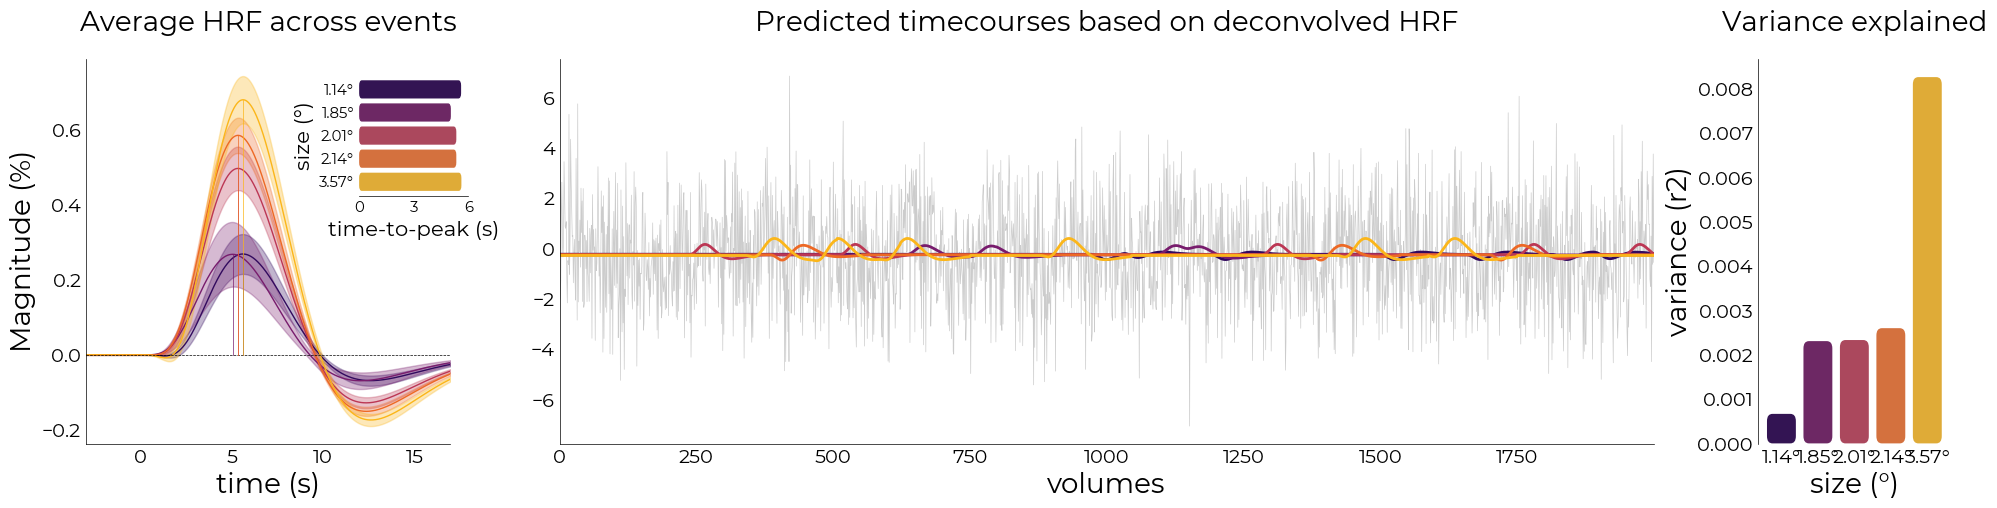

In [310]:
from sklearn.metrics import r2_score

fig = plt.figure(figsize=(24,5))
gs = fig.add_gridspec(1,3, width_ratios=[1,3,0.5], wspace=0.2)
font_size = 20

ax1 = fig.add_subplot(gs[0])
nd_fit.plot_average_per_event(
    axs=ax1,
    x_label="time (s)",
    y_label="Magnitude (%)",
    add_hline='default',
    ttp=True,
    ttp_lines=True,
    add_labels=True,
    y_label2="size (°)",
    x_label2="time-to-peak (s)",
    ttp_labels=[f"{round(float(ii),2)}°" for ii in nd_fit.cond],
    lim=[0, 6],
    ticks=[0,3,6],
    cmap='inferno',
    fancy=True,
    font_size=font_size)

ax2 = fig.add_subplot(gs[1])
colors = sns.color_palette('inferno', len(nd_fit.cond))
preds = [utils.select_from_df(fit_objs[ii].predictions, expression="run = 3").iloc[:,0].values for ii in range(len(fit_objs))]
real = utils.select_from_df(df_ribbon, expression="run = 3").iloc[:, 0].values

plotting.LazyPlot(
    [ii[:2000] for ii in [real]+preds],
    line_width=[0.5]+[2 for ii in range(len(fit_objs))],
    color=["#cccccc"]+colors,
    axs=ax2,
    title="Predicted timecourses based on deconvolved HRF",
    font_size=font_size,
    x_label="volumes")

# calculate r2's
ax3 = fig.add_subplot(gs[2])
r2s = [r2_score(real, preds[ii]) for ii in range(len(fit_objs))]
plotting.LazyBar(
    x=[f"{round(float(ii),2)}°" for ii in nd_fit.cond],
    y=r2s,
    palette=colors,
    sns_ori="v",
    axs=ax3,
    add_labels=True,
    x_label2="size (°)",
    y_label2="variance (r2)",
    font_size=font_size,
    title2="Variance explained",
    fancy_denom=8,
    sns_offset=4,
    fancy=True)


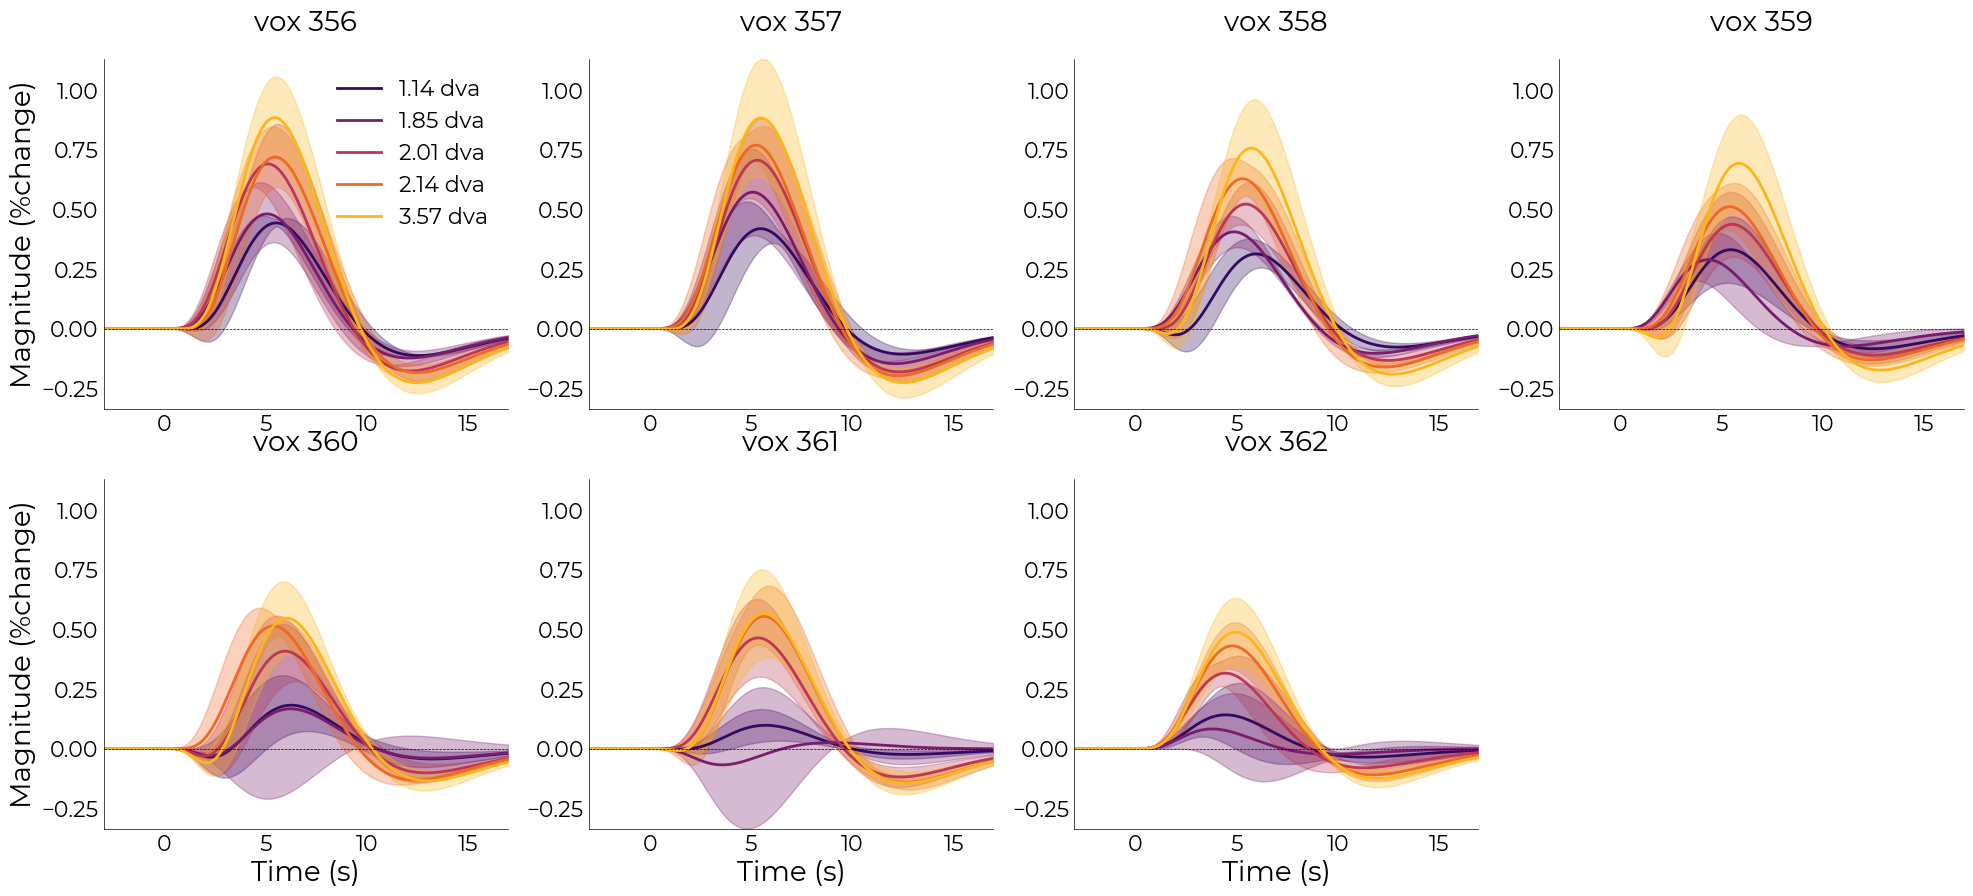

In [314]:
nd_fit.plot_average_per_voxel(
    labels=[f"{round(float(ii),2)} dva" for ii in nd_fit.cond],
    wspace=0.2,
    cmap="inferno",
    line_width=2,
    font_size=font_size,
    label_size=16,
    sharey=True)
    # save_as=opj(func_dir, "hrf_gamma_voxel.png"))


Above, we defined each stimulus size as separate event. To investigate a global response, we can also lump all the events together using `lump_events=True`. This means we'll interpret *any* event as 1 event:

In [289]:
lumped = fitting.NideconvFitter(
    df_ribbon,
    df_onsets,
    confounds=None,
    basis_sets='fourier',
    n_regressors=4,
    lump_events=True,
    TR=0.105,
    interval=[-3,17],
    add_intercept=True,
    verbose=True)

Selected 'fourier'-basis sets
Adding event 'stim' to model
Fitting with 'ols' minimization
Done


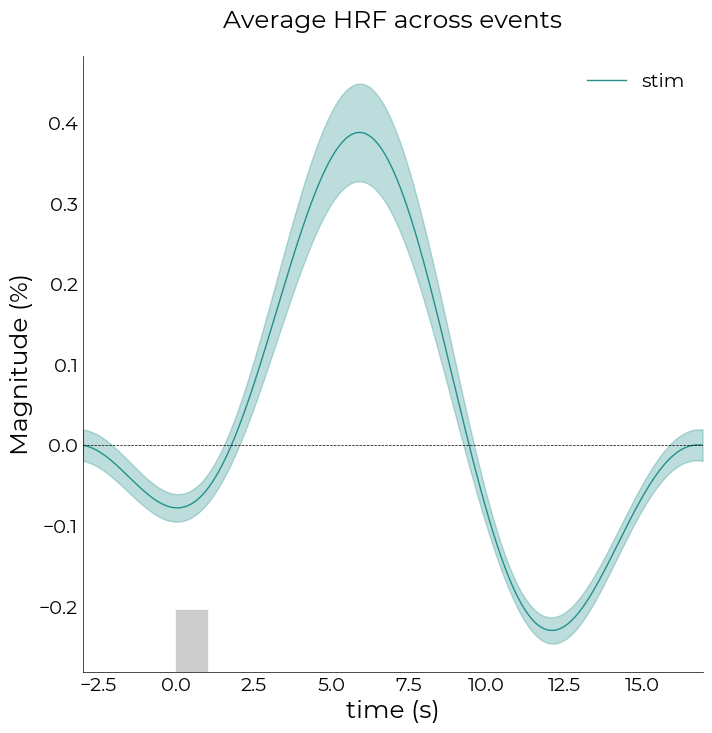

In [293]:
# plot average across voxels
fig,axs = plt.subplots(figsize=(8,8))
lumped.plot_average_per_event(
    labels=['stim'],
    figsize=(8,8),
    axs=axs,
    x_label="time (s)",
    y_label="Magnitude (%)",
    add_hline='default')

# plot stimulus onset 
axs.axvspan(0,1, ymax=0.1, color="#cccccc")


In [294]:
lumped.tc_condition

vox 356   vox 357   vox 358   vox 359  \
event_type covariate time                                                
stim       intercept -3.00000  -0.092421 -0.062954 -0.027623 -0.010078   
                     -2.99475  -0.092423 -0.063035 -0.027751 -0.010080   
                     -2.98950  -0.092427 -0.063118 -0.027881 -0.010082   
                     -2.98425  -0.092431 -0.063201 -0.028011 -0.010086   
                     -2.97900  -0.092435 -0.063285 -0.028142 -0.010091   
...                                  ...       ...       ...       ...   
                      16.92375 -0.092418 -0.062640 -0.027123 -0.010085   
                      16.92900 -0.092418 -0.062717 -0.027247 -0.010081   
                      16.93425 -0.092418 -0.062795 -0.027371 -0.010079   
                      16.93950 -0.092419 -0.062874 -0.027497 -0.010078   
                      16.94475 -0.092421 -0.062954 -0.027623 -0.010078   

                                 vox 360   vox 361   vox 362  
event_type covariate time                                     
stim       intercept -3.00000   0.039126  0.049183  0.003650  
                     -2.99475   0.039143  0.049162  0.003655  
                     -2.98950   0.039158  0.049140  0.003659  
                     -2.98425   0.039172  0.049117  0.003663  
                     -2.97900   0.039184  0.049093  0.003667  
...                                  ...       ...       ...  
                      16.92375  0.039045  0.049252  0.003625  
                      16.92900  0.039067  0.049237  0.003632  
                      16.93425  0.039088  0.049220  0.003638  
                      16.93950  0.039108  0.049202  0.003644  
                      16.94475  0.039126  0.049183  0.003650  

[3800 rows x 7 columns]

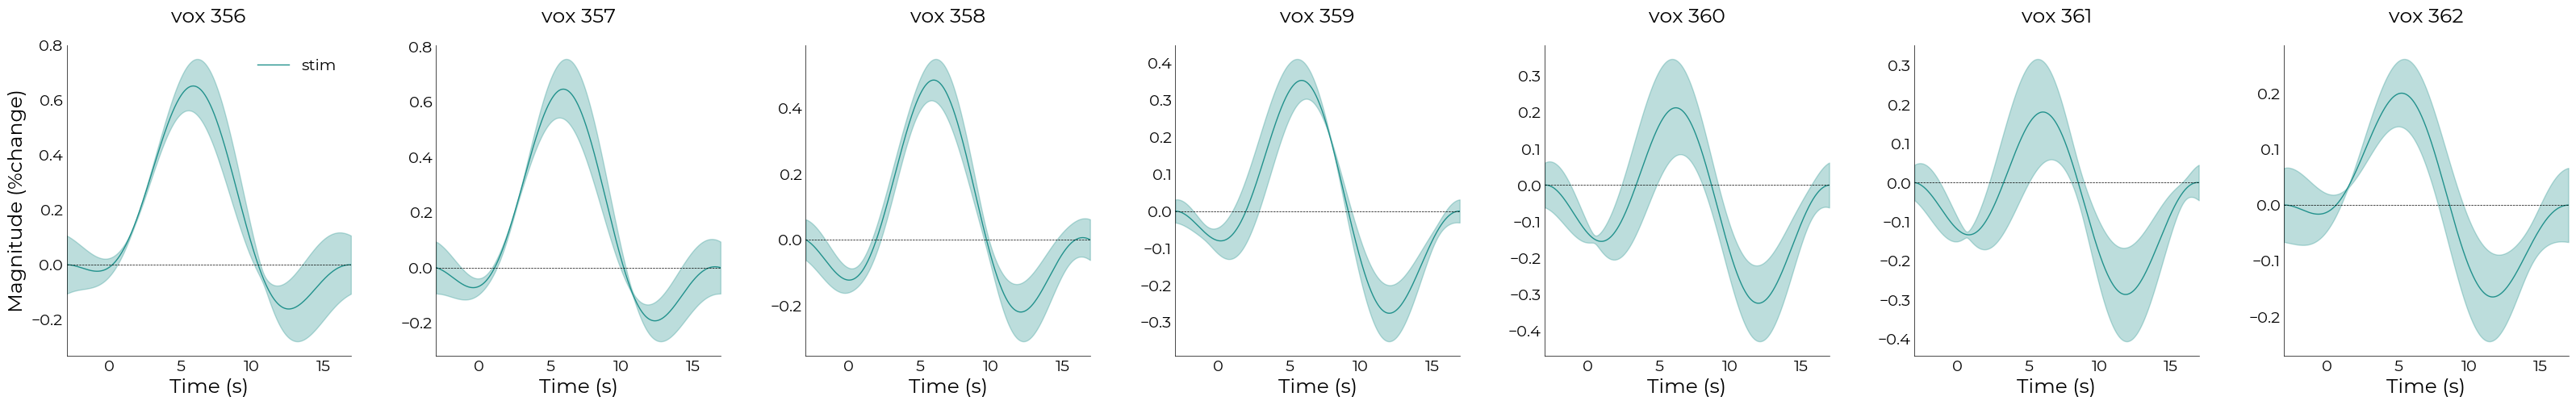

In [295]:
# plot individual voxels in separete figures
lumped.plot_average_per_voxel(
    labels=['stim'], 
    n_cols=7, 
    figsize=(40,5),
    wspace=0.3)

With this lumped-event model, we can also plot the HRFs across depth, independent of stimulus size (left plot). We can then extract the maximums of all HRFs and fit a polynomial to it, revealing a trend towards decreased HRF-amplitude when going from CSF/GM to GM/WM borders

Text(0.5, 1.0, 'Maximum value HRF across depth')

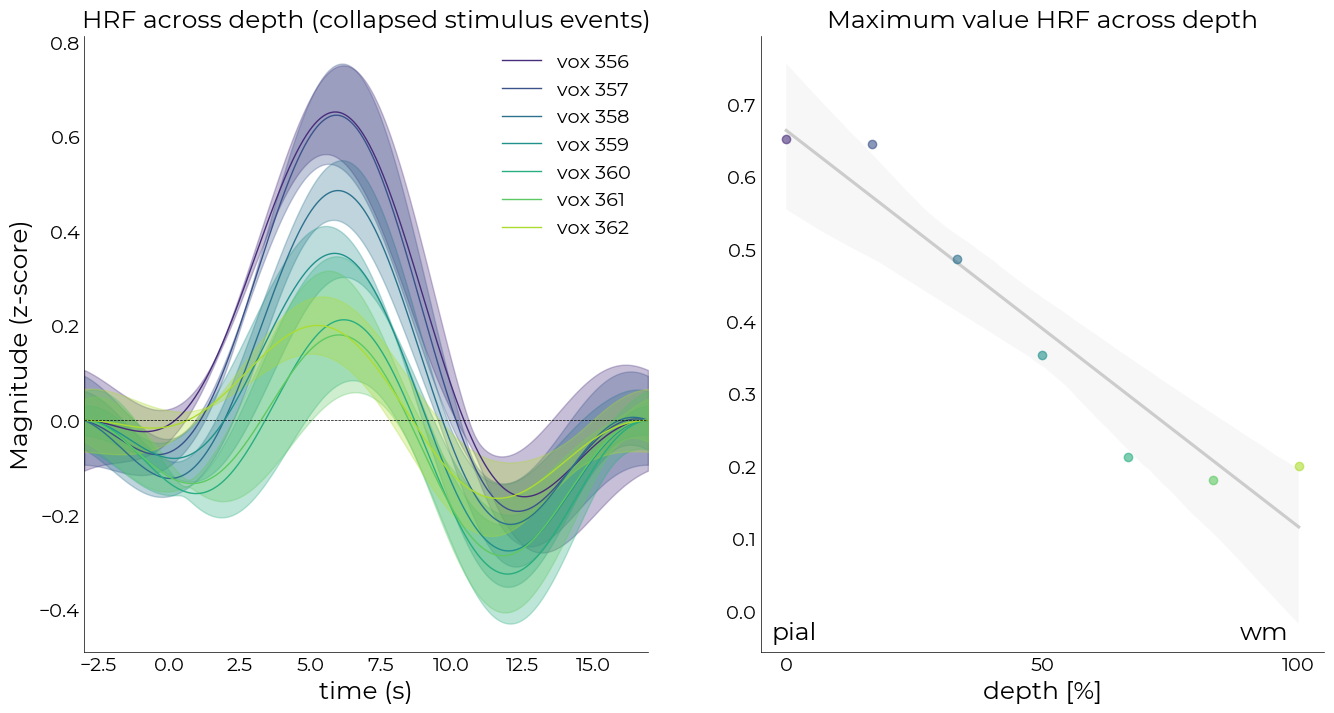

In [322]:
# plot individual voxels in 1 figure
fig = plt.figure(figsize=(16, 8))
gs = fig.add_gridspec(1, 2)

ax = fig.add_subplot(gs[0])
lumped.plot_average_per_voxel(
    n_cols=None, 
    axs=ax, 
    labels=True,
    x_label="time (s)",
    y_label="Magnitude (z-score)",
    set_xlim_zero=False)
ax.set_title("HRF across depth (collapsed stimulus events)", fontsize=lumped.pl.font_size)

ax = fig.add_subplot(gs[1])
lumped.plot_hrf_across_depth(
    axs=ax, 
    order=1,
    x_label="depth [%]")
ax.set_title("Maximum value HRF across depth", fontsize=lumped.pl.font_size)